# Recommender System Testing

The focus of this notebook is to test various code snippest, processing, subcomponents and integration of subcomponents for the recommender system

## Data Processing

External databases are initially used to test and train the recommender system so no actual pre-processing is required for that but when an online version is created and data is logged this will need to be processed and stored. For now the csv ratings file will be loaded and mappings will be created from user and movie ids to indexes. A sparse matrix will then be created to make indexing much easier, for this project double indexing will be done as it is more efficient than having a full sparse matrix.

In [2]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import optuna

external_data_path = "../data/external/"
image_path = "images/"

optuna_optimisation = False
# optuna_optimisation = True

In [3]:
# Choose small or large dataset: False=small, True=large
# large_dataset = True
large_dataset = False
train_ratio = 0.8

if(large_dataset):
    folder_name = external_data_path + "ml-32m"
else:
    folder_name = external_data_path + "ml-latest-small"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []


test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < train_ratio:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 0.5641531944274902 seconds
Train Count: 80629
Test Count: 20207


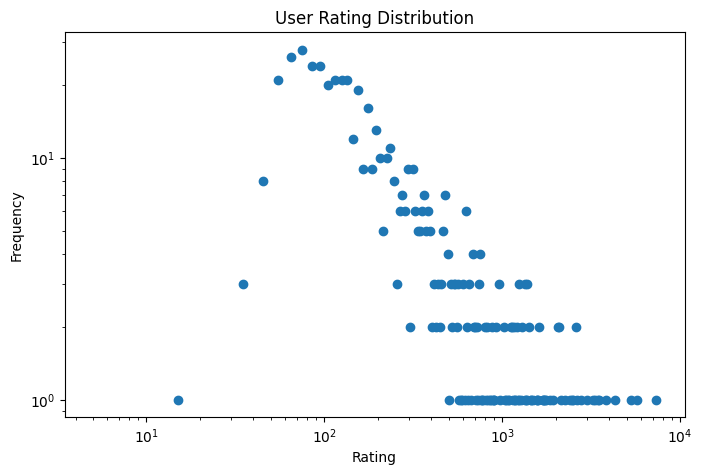

In [4]:
user_total_ratings = []

for row in user_ratings_train:
    user_sum = sum([rating for _, rating in row])
    user_total_ratings.append(user_sum)

all_user_ratings = [rating for rating in user_total_ratings]
user_rating_counts = Counter(all_user_ratings)
user_ratings = np.array(sorted(user_rating_counts.keys()))
user_frequencies = np.array([user_rating_counts[r] for r in user_ratings])

user_bin_edges = np.arange(0, max(user_total_ratings) + 10, 10)
user_frequencies, user_bins = np.histogram(user_total_ratings, bins=user_bin_edges)
user_bin_centers = 0.5 * (user_bins[1:] + user_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(user_bin_centers, user_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('User Rating Distribution')
plt.savefig(image_path + 'user_rating_distribution.svg')
plt.show()

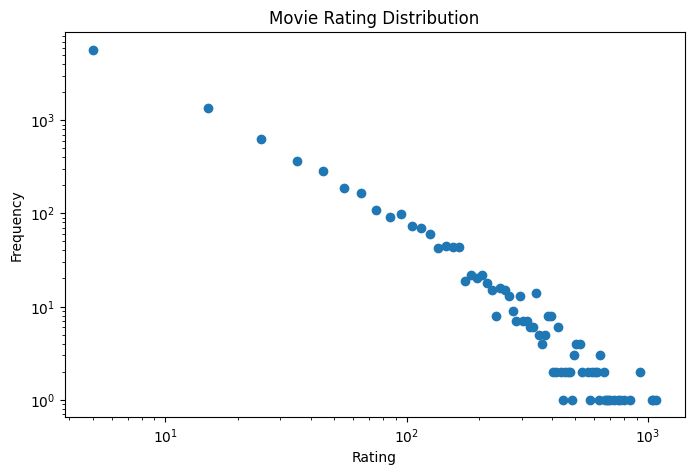

In [5]:
movie_total_ratings = []

for row in movie_ratings_train:
    movie_sum = sum([rating for _, rating in row])
    movie_total_ratings.append(movie_sum)

all_movie_ratings = [rating for rating in movie_total_ratings]
movie_rating_counts = Counter(all_movie_ratings)
movie_ratings = np.array(sorted(movie_rating_counts.keys()))
movie_frequencies = np.array([movie_rating_counts[r] for r in movie_ratings])

movie_bin_edges = np.arange(0, max(movie_total_ratings) + 10, 10)
movie_frequencies, movie_bins = np.histogram(movie_total_ratings, bins=movie_bin_edges)
movie_bin_centers = 0.5 * (movie_bins[1:] + movie_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(movie_bin_centers, movie_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Movie Rating Distribution')
plt.savefig(image_path + 'movie_rating_distribution.svg')
plt.show()

In [6]:
# Hyperparameters
lam = 0.1
gamma = 0.1
num_epochs = 100

# Configure Biases
user_biases = np.zeros(len(user_ratings_train))
item_biases = np.zeros(len(movie_ratings_train))
training_loss = []
training_RMSE = []
testing_RMSE = []

# Estimate biases with loss function
for epoch in range(num_epochs):
    for u in range(len(user_ratings_train)):
        bias = 0
        counter = 0
        for movie_idx, rating in user_ratings_train[u]:
            bias += (rating - item_biases[movie_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        user_biases[u] = bias

    for m in range(len(movie_ratings_train)):
        bias = 0
        counter = 0
        for user_idx, rating in movie_ratings_train[m]:
            bias += (rating - user_biases[user_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        item_biases[m] = bias

    train_loss = 0
    count = 0
    train_error = 0
    for u, user_ratings in enumerate(user_ratings_train):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            train_error += (rating - pred) * (rating - pred)
            count += 1 
    train_rmse = np.sqrt(train_error / (count + 1e-10))
    train_loss = (lam * (train_error)) + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2)))
    training_loss.append(train_loss)
    training_RMSE.append(train_rmse)

    test_loss = 0
    test_error = 0
    count = 0
    for u, user_ratings in enumerate(user_ratings_test):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            test_error += (rating - pred) * (rating - pred)
            count += 1
    test_rmse = np.sqrt(test_error / (count + 1e-10))
    testing_RMSE.append(test_rmse)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Epoch 1/100, Loss: 6244.0587, Train RMSE: 0.8062, Test RMSE: 0.8744
Epoch 2/100, Loss: 6056.3391, Train RMSE: 0.7927, Test RMSE: 0.8624
Epoch 3/100, Loss: 6029.6277, Train RMSE: 0.7917, Test RMSE: 0.8616
Epoch 4/100, Loss: 6013.5076, Train RMSE: 0.7915, Test RMSE: 0.8613
Epoch 5/100, Loss: 6000.3599, Train RMSE: 0.7915, Test RMSE: 0.8611
Epoch 6/100, Loss: 5989.3444, Train RMSE: 0.7915, Test RMSE: 0.8611
Epoch 7/100, Loss: 5980.0900, Train RMSE: 0.7915, Test RMSE: 0.8610
Epoch 8/100, Loss: 5972.3120, Train RMSE: 0.7915, Test RMSE: 0.8611
Epoch 9/100, Loss: 5965.7745, Train RMSE: 0.7915, Test RMSE: 0.8611
Epoch 10/100, Loss: 5960.2795, Train RMSE: 0.7916, Test RMSE: 0.8612
Epoch 11/100, Loss: 5955.6607, Train RMSE: 0.7916, Test RMSE: 0.8612
Epoch 12/100, Loss: 5951.7785, Train RMSE: 0.7916, Test RMSE: 0.8613
Epoch 13/100, Loss: 5948.5154, Train RMSE: 0.7917, Test RMSE: 0.8614
Epoch 14/100, Loss: 5945.7726, Train RMSE: 0.7917, Test RMSE: 0.8615
Epoch 15/100, Loss: 5943.4672, Train RMSE: 

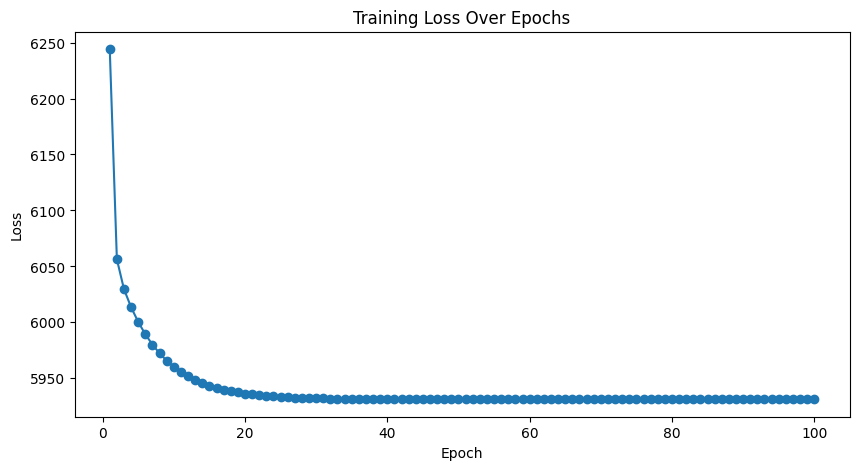

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'bias_trianing_loss.svg')
plt.show()

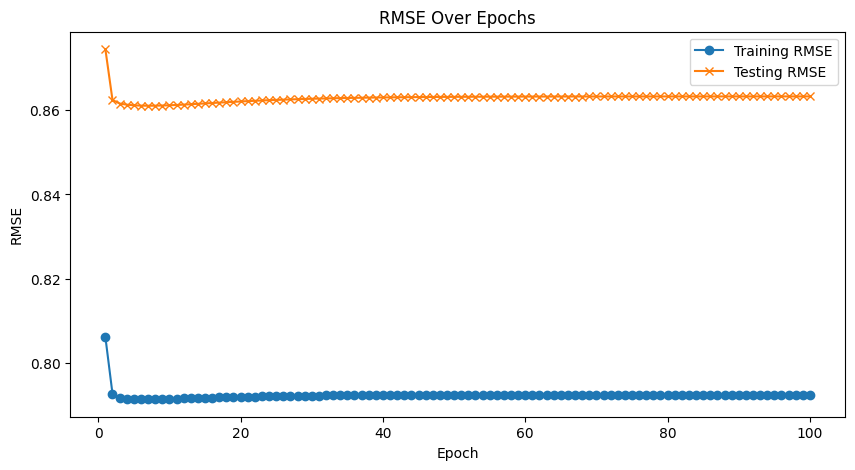

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'bias_rmse.svg')
plt.show()

In [9]:
def training_old(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            bias = 0
            counter = 0
            user = 0
            for movie_idx, rating in user_ratings_train[u]:
                bias += lam * (rating - ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            user_biases[u] = bias
            
            user_term = 0
            user_inverse_term = 0
            for movie_idx, rating in user_ratings_train[u]:
                user_inverse_term += lam * ((item_embeddings[movie_idx].T @ item_embeddings[movie_idx]) + (tau * np.eye(embeddings_dim)))
                user_term += lam * item_embeddings[movie_idx] * (rating - user_biases[u] - item_biases[movie_idx])
            user = np.linalg.solve(user_inverse_term, user_term)
            user_embeddings[u] = user

        for m in range(len(movie_ratings_train)):
            bias = 0
            counter = 0
            for user_idx, rating in movie_ratings_train[m]:
                bias += lam * (rating - ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            item_biases[m] = bias

            item_term = 0
            item_inverse_term = 0
            for user_idx, rating in movie_ratings_train[m]:
                item_inverse_term += lam * ((user_embeddings[user_idx].T @ user_embeddings[user_idx]) + (tau * np.eye(embeddings_dim)))
                item_term += lam * user_embeddings[user_idx] * (rating - user_biases[user_idx] - item_biases[m])
            item = np.linalg.solve(item_inverse_term, item_term)
            item_embeddings[m] = item

        train_loss = 0
        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings.T @ user_embeddings) + np.sum(item_embeddings.T @ item_embeddings)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

In [10]:
def training_optimised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    tau_identity = tau * np.eye(embeddings_dim)

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            counter = 0
            ratings = np.zeros(len(user_ratings_train[u]))
            pred = np.zeros(len(user_ratings_train[u]))
            for movie_idx, rating in user_ratings_train[u]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            user_biases[u] = bias / ((lam * counter) + gamma)
            
            user_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            user_term = np.zeros(embeddings_dim)
            for movie_idx, rating in user_ratings_train[u]:
                item_vec = item_embeddings[movie_idx]
                user_inverse_term += np.outer(item_vec, item_vec)
                user_term += item_vec * (rating - user_biases[u] - item_biases[movie_idx])
            user_inverse_term = (lam * user_inverse_term) + tau_identity
            user_embeddings[u] = np.linalg.solve(user_inverse_term, lam * user_term)

        for m in range(len(movie_ratings_train)):
            counter = 0
            ratings = np.zeros(len(movie_ratings_train[m]))
            pred = np.zeros(len(movie_ratings_train[m]))
            for user_idx, rating in movie_ratings_train[m]:
                ratings[counter] = rating
                pred[counter] = ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx])
                counter += 1
            bias = lam * np.sum(ratings - pred)
            item_biases[m] = bias / ((lam * counter) + gamma)

            item_inverse_term = np.zeros((embeddings_dim, embeddings_dim))
            item_term = np.zeros(embeddings_dim)
            for user_idx, rating in movie_ratings_train[m]:
                user_vec = user_embeddings[user_idx]
                item_inverse_term += np.outer(user_vec, user_vec)
                item_term += user_vec * (rating - user_biases[user_idx] - item_biases[m])
            item_inverse_term = (lam * item_inverse_term) +  tau_identity
            item = np.linalg.solve(item_inverse_term, lam * item_term)
            item_embeddings[m] = item

        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings**2) + np.sum(item_embeddings**2)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u] @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

In [11]:
# Hyperparameters
lam = 1
gamma = 1
tau = 10
num_epochs = 20
embeddings_dim = 10
const = 1

scale = const/np.sqrt(embeddings_dim)
training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings = training_optimised(
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)

Epoch 1/20, Loss: 62447.1493, Train RMSE: 0.7906, Test RMSE: 0.8740
Epoch 2/20, Loss: 57293.4537, Train RMSE: 0.7233, Test RMSE: 0.8574
Epoch 3/20, Loss: 54553.0576, Train RMSE: 0.6701, Test RMSE: 0.8584
Epoch 4/20, Loss: 53748.1987, Train RMSE: 0.6543, Test RMSE: 0.8587
Epoch 5/20, Loss: 53349.5070, Train RMSE: 0.6479, Test RMSE: 0.8580
Epoch 6/20, Loss: 53095.0636, Train RMSE: 0.6446, Test RMSE: 0.8571
Epoch 7/20, Loss: 52911.8679, Train RMSE: 0.6425, Test RMSE: 0.8563
Epoch 8/20, Loss: 52771.3930, Train RMSE: 0.6412, Test RMSE: 0.8557
Epoch 9/20, Loss: 52659.7372, Train RMSE: 0.6402, Test RMSE: 0.8552
Epoch 10/20, Loss: 52568.9377, Train RMSE: 0.6394, Test RMSE: 0.8549
Epoch 11/20, Loss: 52493.9032, Train RMSE: 0.6388, Test RMSE: 0.8547
Epoch 12/20, Loss: 52431.1243, Train RMSE: 0.6383, Test RMSE: 0.8545
Epoch 13/20, Loss: 52378.0483, Train RMSE: 0.6379, Test RMSE: 0.8545
Epoch 14/20, Loss: 52332.7477, Train RMSE: 0.6376, Test RMSE: 0.8544
Epoch 15/20, Loss: 52293.7323, Train RMSE: 

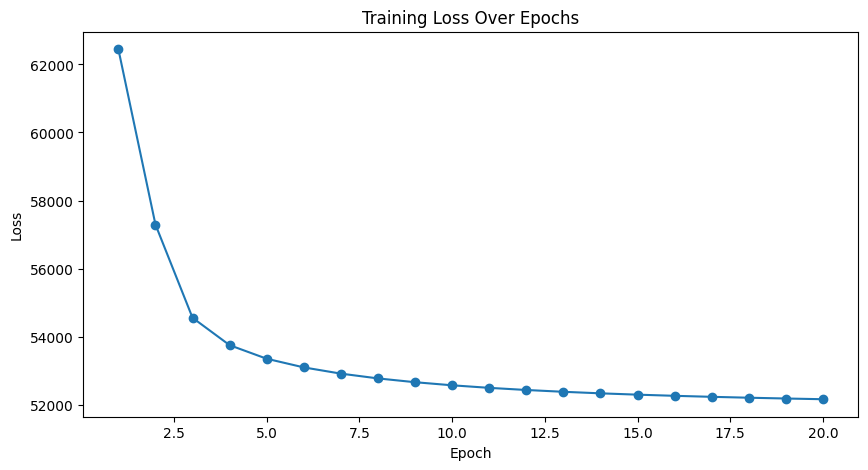

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'embeddings_trianing_loss.svg')
plt.show()

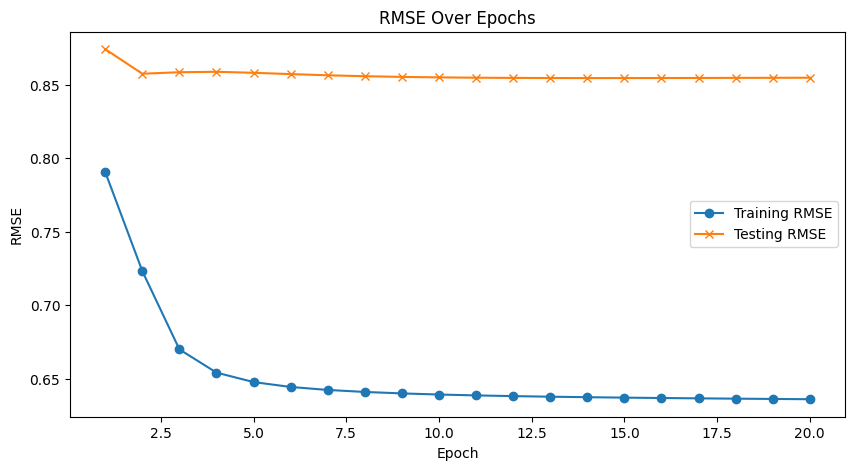

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'embeddings_rmse.svg')
plt.show()

In [14]:
def objective(trial):
    lam = trial.suggest_float('lam', 1e-5, 1.0, log=True)
    gamma = trial.suggest_float('gamma', 1e-5, 1.0, log=True)
    tau = trial.suggest_float('tau', 1e-5, 1.0, log=True)
    embeddings_dim = trial.suggest_int('embeddings_dim', 10, 100)
    scale = trial.suggest_float('scale', 0.01, 1.0)

    num_epochs = 20
    
    training_loss, training_RMSE, testing_RMSE, _, _ = training_optimised(
        num_epochs=num_epochs,
        lam=lam,
        gamma=gamma,
        tau=tau,
        embeddings_dim=embeddings_dim,
        scale=scale
    )

    return testing_RMSE[-1]

In [15]:
best_params = {}
best_rmse = 0
if(optuna_optimisation):
    study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=50)
    best_params = study.best_params
    best_rmse = study.best_value
    with open('best_hyperparams.txt', 'w') as f:
        for param, value in study.best_params.items():
            f.write(f"{param}: {value}\n")
        f.write(f"Best Test RMSE: {study.best_value}\n")

else:
    with open('best_hyperparams.txt', 'r') as f:
        for line in f:
            if ':' in line:
                key, value = line.strip().split(':')
                key = key.strip()
                value = value.strip()
                if key == 'Best Test RMSE':
                    best_rmse = float(value)
                else:
                    # Attempt to parse int, then float, else keep string
                    try:
                        value = int(value)
                    except ValueError:
                        try:
                            value = float(value)
                        except ValueError:
                            pass
                    best_params[key] = value

print("Best Hyperparameters:", best_params)
print("Best Test RMSE:", best_rmse)



Best Hyperparameters: {'lam': 0.00031125036498203445, 'gamma': 0.000152943730405528, 'tau': 0.004642755802877007, 'embeddings_dim': 90, 'scale': 0.47893199201972436}
Best Test RMSE: 0.853620095792125


In [16]:
def training_optimised_vectorised(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    num_users = len(user_ratings_train)
    num_items = len(movie_ratings_train)
    
    user_embeddings = np.random.normal(0, scale, (num_users, embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (num_items, embeddings_dim))
    user_biases = np.zeros(num_users)
    item_biases = np.zeros(num_items)

    tau_identity = tau * np.eye(embeddings_dim)

    training_loss, training_RMSE, testing_RMSE = [], [], []

    for epoch in range(num_epochs):
        # USER UPDATE
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            item_vecs = item_embeddings[movies]
            item_bias = item_biases[movies]

            preds = (item_vecs @ user_embeddings[u]) + item_bias
            residuals = actual_ratings - preds

            user_biases[u] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_biases[u] - item_bias
            user_inverse_term = lam * (item_vecs.T @ item_vecs) + tau_identity
            user_term = lam * (item_vecs.T @ adjusted_residuals)

            user_embeddings[u] = np.linalg.solve(user_inverse_term, user_term)

        # ITEM UPDATE
        for m, ratings in enumerate(movie_ratings_train):
            users = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            user_vecs = user_embeddings[users]
            user_bias = user_biases[users]

            preds = (user_vecs @ item_embeddings[m]) + user_bias
            residuals = actual_ratings - preds

            item_biases[m] = lam * np.sum(residuals) / ((lam * len(ratings)) + gamma)

            adjusted_residuals = actual_ratings - user_bias - item_biases[m]
            item_inverse_term = lam * (user_vecs.T @ user_vecs) + tau_identity
            item_term = lam * (user_vecs.T @ adjusted_residuals)

            item_embeddings[m] = np.linalg.solve(item_inverse_term, item_term)

        # --- Training RMSE ---
        train_preds, train_actuals = [], []
        for u, ratings in enumerate(user_ratings_train):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            train_preds.append(preds)
            train_actuals.append(actual_ratings)

        train_preds = np.concatenate(train_preds)
        train_actuals = np.concatenate(train_actuals)

        train_error = np.sum((train_actuals - train_preds) ** 2)
        train_rmse = np.sqrt(train_error / len(train_actuals))

        train_loss = (lam * train_error) \
            + (gamma * (np.sum(user_biases ** 2) + np.sum(item_biases ** 2))) \
            + (tau * (np.sum(user_embeddings ** 2) + np.sum(item_embeddings ** 2)))
        
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        # --- Testing RMSE ---
        test_preds, test_actuals = [], []
        for u, ratings in enumerate(user_ratings_test):
            movies = np.array([idx for idx, _ in ratings], dtype=int)
            actual_ratings = np.array([r for _, r in ratings])

            preds = (user_embeddings[u] @ item_embeddings[movies].T) + user_biases[u] + item_biases[movies]
            test_preds.append(preds)
            test_actuals.append(actual_ratings)

        test_preds = np.concatenate(test_preds)
        test_actuals = np.concatenate(test_actuals)

        test_error = np.sum((test_actuals - test_preds) ** 2)
        test_rmse = np.sqrt(test_error / len(test_actuals))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings


In [17]:
scale = const/np.sqrt(embeddings_dim)
training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings = training_optimised_vectorised(
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)

Epoch 1/20, Loss: 62503.5470, Train RMSE: 0.7920, Test RMSE: 0.8743
Epoch 2/20, Loss: 57425.5042, Train RMSE: 0.7259, Test RMSE: 0.8611
Epoch 3/20, Loss: 54761.0675, Train RMSE: 0.6737, Test RMSE: 0.8619
Epoch 4/20, Loss: 53890.6683, Train RMSE: 0.6569, Test RMSE: 0.8620
Epoch 5/20, Loss: 53442.6128, Train RMSE: 0.6495, Test RMSE: 0.8608
Epoch 6/20, Loss: 53142.5072, Train RMSE: 0.6452, Test RMSE: 0.8595
Epoch 7/20, Loss: 52921.9658, Train RMSE: 0.6423, Test RMSE: 0.8583
Epoch 8/20, Loss: 52753.3480, Train RMSE: 0.6403, Test RMSE: 0.8574
Epoch 9/20, Loss: 52621.5752, Train RMSE: 0.6389, Test RMSE: 0.8567
Epoch 10/20, Loss: 52517.0857, Train RMSE: 0.6379, Test RMSE: 0.8562
Epoch 11/20, Loss: 52433.2197, Train RMSE: 0.6371, Test RMSE: 0.8559
Epoch 12/20, Loss: 52365.1076, Train RMSE: 0.6365, Test RMSE: 0.8557
Epoch 13/20, Loss: 52309.1425, Train RMSE: 0.6361, Test RMSE: 0.8556
Epoch 14/20, Loss: 52262.6524, Train RMSE: 0.6357, Test RMSE: 0.8555
Epoch 15/20, Loss: 52223.6528, Train RMSE: 

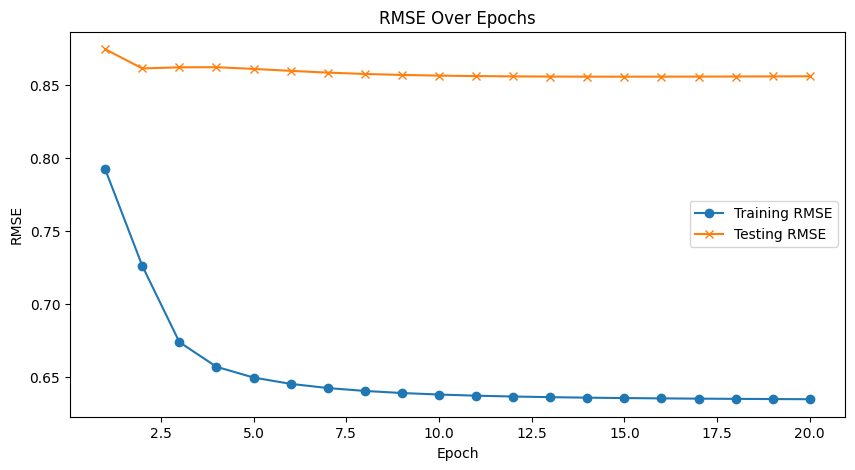

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'embeddings_rmse.svg')
plt.show()

In [22]:
folder_name = external_data_path + "ml-32m"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

In [23]:
# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []


test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < train_ratio:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 125.86512160301208 seconds
Train Count: 25601402
Test Count: 6398802


In [24]:
scale = const/np.sqrt(embeddings_dim)
training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings = training_optimised_vectorised(
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)

Epoch 1/20, Loss: 20839059.8685, Train RMSE: 0.8311, Test RMSE: 0.8833
Epoch 2/20, Loss: 18461266.0577, Train RMSE: 0.7716, Test RMSE: 0.8344
Epoch 3/20, Loss: 17307328.2655, Train RMSE: 0.7415, Test RMSE: 0.8056
Epoch 4/20, Loss: 16776435.5799, Train RMSE: 0.7280, Test RMSE: 0.7923
Epoch 5/20, Loss: 16511275.8516, Train RMSE: 0.7217, Test RMSE: 0.7863
Epoch 6/20, Loss: 16356909.3161, Train RMSE: 0.7186, Test RMSE: 0.7834
Epoch 7/20, Loss: 16252854.5035, Train RMSE: 0.7169, Test RMSE: 0.7819
Epoch 8/20, Loss: 16174475.2018, Train RMSE: 0.7159, Test RMSE: 0.7810
Epoch 9/20, Loss: 16110761.4382, Train RMSE: 0.7152, Test RMSE: 0.7805
Epoch 10/20, Loss: 16056226.7154, Train RMSE: 0.7148, Test RMSE: 0.7802
Epoch 11/20, Loss: 16007853.0049, Train RMSE: 0.7145, Test RMSE: 0.7799
Epoch 12/20, Loss: 15963850.2621, Train RMSE: 0.7142, Test RMSE: 0.7798
Epoch 13/20, Loss: 15923099.5402, Train RMSE: 0.7140, Test RMSE: 0.7797
Epoch 14/20, Loss: 15884874.1915, Train RMSE: 0.7139, Test RMSE: 0.7796
E

In [ ]:
save_dir = os.path.join("..", "models")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "recommender_model_params.npz")

np.savez_compressed(
    save_path,
    user_embeddings=user_embeddings,
    item_embeddings=item_embeddings,
    user_biases=user_biases,
    item_biases=item_biases
)


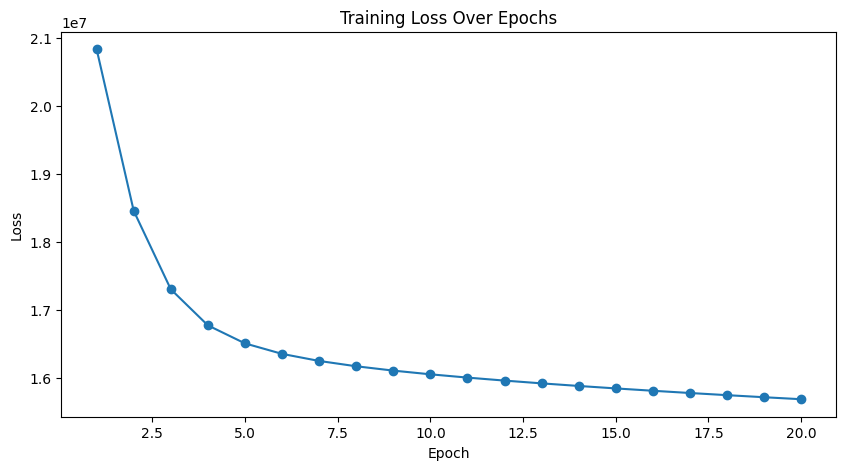

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'large_embeddings_trianing_loss.svg')
plt.show()

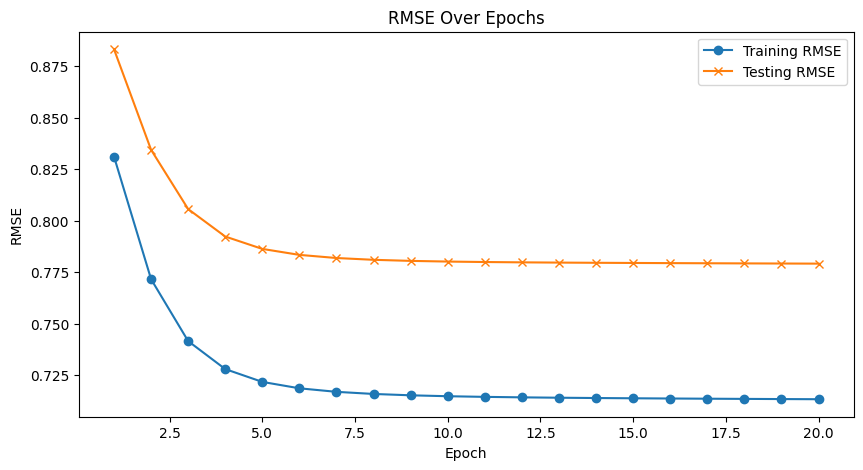

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'large_embeddings_rmse.svg')
plt.show()